# (MultiFiT) French Sentiment Classifier on French Amazon Customer Reviews
### (architecture 4 QRNN with 1550 hidden parameters by layer, SentencePiece tokenizer and hyperparameters from the MultiFiT method)

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: September 2019
- Post in medium: [link](https://medium.com/@pierre_guillou/nlp-fastai-french-language-model-d0e2a9e12cab)
- Ref: [Fastai v1](https://docs.fast.ai/) (Deep Learning library on PyTorch)

**Information**

According to this new article "[MultiFiT: Efficient Multi-lingual Language Model Fine-tuning](https://arxiv.org/abs/1909.04761)" (September 10, 2019), the QRNN architecture and the SentencePiece tokenizer give better results than AWD-LSTM and the spaCy tokenizer respectively. 

Therefore, they have been used in this notebook to **fine-tune a French bidirectional Language Model** by Transfer Learning of a French bidirectional Language Model (with the QRNN architecture and the SentencePiece tokenizer, too) trained on a Wikipedia corpus of 100 millions tokens ([lm2-french.ipynb](https://github.com/piegu/language-models/blob/master/lm2-french.ipynb)). 

This French bidirectional Language Model has been **fine-tuned on "[French Amazon Customer Reviews](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)"** and **its encoder part has been transfered to a sentiment classifier which has been finally trained on this amazon corpus**.

This process **LM General --> LM fine-tuned --> Classifier fine-tuned** is called [ULMFiT](http://nlp.fast.ai/category/classification.html).

More, the following hyperparameters values given at the end of the MultiFiT article have been used:
- Language Model
    - (batch size) bs = 50
    - (QRNN) 3 QRNN (default: 3) with 1152 hidden parameters each one (default: 1152) (note: it would have been better to increae to 4 QRNN with 1550 hidden parameters like described in the article)
    - (SentencePiece) vocab of 15000 tokens
    - (dropout) mult_drop = 0
    - (weight decay) wd = 0.01
    - (number of training epochs) 20 epochs
    

- Sentiment Classifier
    - (batch size) bs = 18
    - (SentencePiece) vocab of 15000 tokens
    - (dropout) mult_drop = 0.5
    - (weight decay) wd = 0.01
    - (number of training epochs) 10 epochs
    - (loss) FlattenedLoss of weighted CrossEntropyLoss

## Results

Our Bidirectional French LM ([lm3-french.ipynb](https://github.com/piegu/language-models/blob/master/lm3-french.ipynb)) and Sentiment Classifier with a MultiFiT configuration (4 QRNN architecture, 1550 hidden parameters and using the SentencePiecce tokenizer) ([lm3-french-classifier-amazon.ipynb](https://github.com/piegu/language-models/blob/master/lm3-french-classifier-amazon.ipynb)) have better results (accuracy, perplexity and f1) than the 2 others Bidirectional French LM ([lm-french.ipynb](https://github.com/piegu/language-models/blob/master/lm-french.ipynb) and [lm2-french.ipynb](https://github.com/piegu/language-models/blob/master/lm2-french.ipynb)) we have trained before.

This improvement comes from:
- the deeper complexity of our last Bidirectional French LMs and Sentiment Classifier that use the MultiFiT configuration (4 QRNN architecture with 1550 hidden parameters): 4 layers instead of 3 and each hidden layer has more parameters.
- the use of the SentencePiecce tokenizer (even with only a vocab of 15 000 tokens instead of 60 000 with the spaCy tokenizer)

**We can conclude that this Bidirectional French LM model using the MultiFiT configuration is a good model to perform text classification but with only 46 millions of parameters, it is far from being a LM that can gan compete with [GPT-2](https://openai.com/blog/better-language-models/) or [BERT](https://arxiv.org/abs/1810.04805) in NLP tasks like text generation.**

- **About the data**: the dataset "French Amazon Customer Reviews", even after pre-processing (deleting empty reviews, neutral ones, etc.), is unbalanced. Therefore, we used a weighted loss function (FlattenedLoss of weighted CrossEntropyLoss).
    - initial number of reviews: 253 961
    - number of reviews after pre-processing: 221 456
        - neg: 25106 (11.34%)
        - pos: 196350 (88.66%)


- **(fine-tuned) Language Model**   
    - forward : (accuracy) 37.57% | (perplexity) 24.62
    - backward: (accuracy) 43.25% | (perplexity) 24.90
    

- **(fine-tuned) Sentiment Classifier**

    - **Accuracy**
        - forward : (global) 95.33% | **(neg) 91.79%** | (pos) 95.76%
        - backward: (global) 95.68% | (neg) 88.47% | **(pos) 96.56%**
        - ensemble: **(global) 95.92%** | (neg) 91.04% | (pos) 96.51%

    - **f1 score**
        - forward: 0.9624
        - backward: 0.9606
        - ensemble: **0.9636**
   

(neg = negative reviews | pos = positive reviews)

### To be improved

The lost function FlattenedLoss of LabelSmoothingCrossEntropy should be tested as it is used in the MultiFiT method (see the notebook [lm3-portuguese-classifier-TCU-jurisprudencia.ipynb](https://github.com/piegu/language-models/blob/master/lm3-portuguese-classifier-TCU-jurisprudencia.ipynb) to get the code).

## Initialisation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [2]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [3]:
# bs=48
# bs=24
bs=50

In [4]:
torch.cuda.set_device(0)

In [5]:
data_path = Config.data_path()

This will create a `{lang}wiki` folder, containing a `{lang}wiki` text file with the wikipedia contents. (For other languages, replace `{lang}` with the appropriate code from the [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias).)

In [6]:
lang = 'fr'

In [7]:
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

lm_fns3 = [f'{lang}_wt_sp15_multifit', f'{lang}_wt_vocab_sp15_multifit']
lm_fns3_bwd = [f'{lang}_wt_sp15_multifit_bwd', f'{lang}_wt_vocab_sp15_multifit_bwd']

## Data

- [French Amazon Customer Reviews](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)
- [Guide on how to download the French Amazon Customer Reviews](https://forums.fast.ai/t/ulmfit-french/29379/36)
- File: amazon_reviews_multilingual_FR_v1_00.tsv.gz

In [8]:
name = 'amazon_reviews_fr'
path_data = data_path/name
path_data.ls()

[PosixPath('/home/jupyter/.fastai/data/amazon_reviews_fr/amazon_reviews_multilingual_FR_v1_00.tsv'),
 PosixPath('/home/jupyter/.fastai/data/amazon_reviews_fr/amazon_reviews_filtered_fr.csv'),
 PosixPath('/home/jupyter/.fastai/data/amazon_reviews_fr/amazon_reviews_fr.csv')]

### Run this code the first time

#### Get reviews neg and pos

In [9]:
# to solve display error of pandas dataframe
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [10]:
fields = ['review_id', 'review_body', 'star_rating']
df = pd.read_csv(path_data/'amazon_reviews_multilingual_FR_v1_00.tsv', delimiter='\t',encoding='utf-8', usecols=fields)
df = df[fields]
df.loc[pd.isna(df.review_body),'review_body']='NA'
df.head()

,review_id,review_body,star_rating
0,R32VYUWDIB5LKE,je conseille fortement ce bouquin à ceux qui s...,5
1,R3CCMP4EV6HAVL,"ce magnifique est livre , les personnages sont...",5
2,R14NAE6UGTVTA2,Je dirais qu'il a un défaut :<br />On ne peut ...,3
3,R2E7QEWSC6EWFA,Je l'ai depuis quelques jours et j'en suis trè...,4
4,R26E6I47GQRYKR,"je m'attendait à un bon film, car j'aime beauc...",2


In [19]:
# columns names
reviews = "review_body"
idx = "review_id"
rating = "star_rating"
label = "label"

# keep not null reviews
df2 = df.copy()

In [20]:
# number of reviews
print(f'(orginal csv) number of all reviews: {len(df)}')

df2 = df.copy()

# keep not null reviews
empty = (df2[reviews].isnull()).sum()
df2 = df2[df2[reviews].notnull()]
if empty != 0:
    print(f'{empty} empty reviews were deleted')
else:
    print('there is no empty review.')

# check that there is no twice the same review
# keep the first of unique review_id reviews
same = len(df2) - len(df2[idx].unique())
if same != 0:
    df2.drop_duplicates(subset=[idx], inplace=True)
    print(f'from the {same} identical reviews ids, only the first one has been kept.')
else:
    print('there is no identical review id.')

# categorify reviews in 2 classes neg, pos in the label column (rating != 3)
neutral = len(df2[df2[rating] == 3])
df2 = df2[df2[rating] != 3]
df2[label] = 'neg'
df2.loc[df2[rating] > 3, label] = 'pos'
print(f'{neutral} neutral reviews (rating = 3) were deleted')

# number of reviews neg or pos
num_neg = len(df2[df2[label] == 'neg'])
num_pos = len(df2[df2[label] == 'pos'])
num_neg_pos = len(df2)
pc_neg = round((num_neg/num_neg_pos)*100,2)
pc_pos = round((num_pos/num_neg_pos)*100,2)
print(f'\nnumber of neg reviews (rating = 1 or 2): {num_neg} ({pc_neg}%)')
print(f'number of pos reviews (rating = 4 or 5): {num_pos} ({pc_pos}%)')
print(f'\n(final) number of all reviews neg and pos: {num_neg_pos}')  

# convert HTML caracters to normal letters
df2[reviews] = df2[reviews].apply(convert)

df2[[reviews, rating]].head(10)

(orginal csv) number of all reviews: 253961
there is no empty review.
there is no identical review id.
23277 neutral reviews (rating = 3) were deleted

number of neg reviews (rating = 1 or 2): 25637 (11.11%)
number of pos reviews (rating = 4 or 5): 205047 (88.89%)

(final) number of all reviews neg and pos: 230684


,review_body,star_rating
0,je conseille fortement ce bouquin à ceux qui s...,5
1,"ce magnifique est livre , les personnages sont...",5
3,Je l'ai depuis quelques jours et j'en suis trè...,4
4,"je m'attendait à un bon film, car j'aime beauc...",2
5,Ne disait pas sur l'annonce que c'était un 10'...,2
6,"du bon bowie,très bon meme parfois.esperons qu...",5
7,très bon film beaucoup d'action l'image est le...,5
8,Un sujet délicat mais parfaitement traité avec...,5
9,Un coffret d'un duo culte que les DVD nous per...,5
10,"Un grand classique dans ce genre de films, mai...",5


#### Delete the non French reviews

**FastText**

- library source: https://github.com/facebookresearch/fastText/tree/master/python
- Blog post about using fasttext for language detection: https://amitness.com/2019/07/identify-text-language-python/
- "New release of python module" (june 2019): https://fasttext.cc/blog/2019/06/25/blog-post.html

In [24]:
import fasttext
import urllib.request
from converter import *

In [25]:
# Download the file from url and save it locally under file_name
# source: https://fasttext.cc/docs/en/language-identification.html

path_ft = Path.cwd() # /home/jupyter/tutorials/fastai/course-nlp
url = 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'
file_name = 'lid.176.bin'
url_file = path_ft/file_name
urllib.request.urlretrieve(url, url_file)

(PosixPath('/home/jupyter/tutorials/fastai/course-nlp/lid.176.bin'),
 <http.client.HTTPMessage at 0x7f2f633f6490>)

In [26]:
# get the model trained on 176 languages
model = fasttext.load_model(file_name)

In [27]:
# test
sentences = ['Il fait très beau']
predictions = model.predict(sentences)
print(predictions[0][0][0].replace('__label__','') == 'fr')
print(predictions)

True
([['__label__fr']], array([[1.000027]]))


In [28]:
%%time
list_idx = []
for idx, row in df2.iterrows():
    try:
        string = str(row[reviews]).replace('\r',' ').replace('\n','').replace('<br />', ' ').lower()
        predictions = model.predict(string)
        language = predictions[0][0].replace('__label__','')
    except:
        language = "error"
    if not (language == 'fr'):
        list_idx.append(idx)
        
print(f'number of non-French reviews: {len(list_idx)}')

number of non-French reviews: 9228
CPU times: user 39.9 s, sys: 44 ms, total: 40 s
Wall time: 40 s


In [29]:
df2[reviews][list_idx][:10]

16     Just great complination, there are 48 cds insi...
19     I know it's a classic but really it is a marve...
20     Waiting for so long to get a sequel of Bridget...
72     Not one of his best science fiction novels but...
126    Für die  Liebhaber von Schwarzer Humor  ist di...
165    A great alternate look into the world of cats,...
194    It's the perfect book for a screenwriter and a...
238    Good delivery, on time. However the image of t...
376    This is Frank Herbert's masterpiece and should...
379    It was by sheer chance that I came across this...
Name: review_body, dtype: object

In [30]:
df2.drop(list_idx, axis=0, inplace=True)
df_trn_val = df2.copy()

#### Save filtered reviews dataset

number of neg reviews (rating = 1 or 2): 25106 (11.34%)
number of pos reviews (rating = 4 or 5): 196350 (88.66%)
number of all reviews: 221456


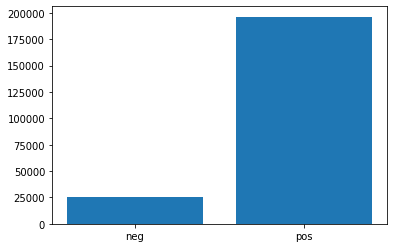

In [32]:
# number of reviews neg or pos
num_neg = len(df_trn_val[df_trn_val[label] == 'neg'])
num_pos = len(df_trn_val[df_trn_val[label] == 'pos'])
num_neg_pos = len(df_trn_val)
pc_neg = round((num_neg/num_neg_pos)*100,2)
pc_pos = round((num_pos/num_neg_pos)*100,2)
print(f'number of neg reviews (rating = 1 or 2): {num_neg} ({pc_neg}%)')
print(f'number of pos reviews (rating = 4 or 5): {num_pos} ({pc_pos}%)')
print(f'number of all reviews: {num_neg_pos}') 

# plot histogram
x= [1,2]
keys = list(df_trn_val[label].value_counts().keys())
values = list(df_trn_val[label].value_counts().array)
plt.bar(x, values[::-1]) 
plt.xticks(x, keys[::-1])
# print(df_trn_val['label'].value_counts())
plt.show()

In [33]:
df_trn_val.to_csv (path_data/'amazon_reviews_filtered_fr.csv', index = None, header=True)

### Get the csv of pre-processed data 

In [9]:
df_trn_val = pd.read_csv(path_data/'amazon_reviews_filtered_fr.csv')
df_trn_val.head()

,review_id,review_body,star_rating,label
0,R32VYUWDIB5LKE,je conseille fortement ce bouquin à ceux qui s...,5,pos
1,R3CCMP4EV6HAVL,"ce magnifique est livre , les personnages sont...",5,pos
2,R2E7QEWSC6EWFA,Je l'ai depuis quelques jours et j'en suis trè...,4,pos
3,R26E6I47GQRYKR,"je m'attendait à un bon film, car j'aime beauc...",2,neg
4,R1RJMTSNCKB9LP,Ne disait pas sur l'annonce que c'était un 10'...,2,neg


## Fine-tuning "forward LM"

### Databunch

In [36]:
%%time
data_lm = (TextList.from_df(df_trn_val, path, cols='review_body', 
                            processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

CPU times: user 5min 42s, sys: 4.13 s, total: 5min 46s
Wall time: 3min 20s


In [37]:
data_lm.save(f'{path}/{lang}_databunch_lm_aws_sp15_multifit')

### Training

In [38]:
data_lm = load_data(path, f'{lang}_databunch_lm_aws_sp15_multifit', bs=bs)

In [39]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [40]:
%%time
perplexity = Perplexity()
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=lm_fns3, drop_mult=0.3, 
                                  metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 4.15 s, sys: 1.78 s, total: 5.93 s
Wall time: 5.52 s


In [41]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


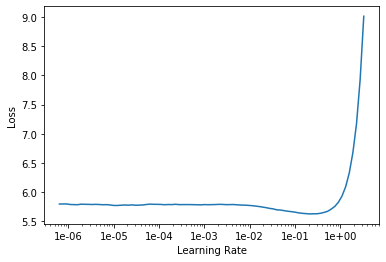

In [42]:
learn_lm.recorder.plot()

In [43]:
lr = 1e-3
lr *= bs/48

wd = 0.01

In [44]:
learn_lm.fit_one_cycle(2, lr*10, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,4.244709,3.975198,0.716463,0.283537,53.260723,04:46
1,4.097570,3.809512,0.700321,0.299680,45.128353,04:47


In [45]:
learn_lm.save(f'{lang}fine_tuned1_sp15_multifit')
learn_lm.save_encoder(f'{lang}fine_tuned1_enc_sp15_multifit')

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.854347,3.681821,0.686109,0.313891,39.718689,06:33
1,3.693963,3.566552,0.672203,0.327797,35.394287,06:34
2,3.604823,3.477466,0.661110,0.338889,32.377483,06:33
3,3.532686,3.419939,0.654247,0.345753,30.567617,06:34
4,3.448142,3.378420,0.649205,0.350795,29.324419,06:33
5,3.397948,3.344656,0.644829,0.355171,28.350889,06:34
6,3.383170,3.318856,0.641322,0.358678,27.628752,06:33
7,3.335981,3.298017,0.638546,0.361455,27.058929,06:34
8,3.335056,3.279595,0.635979,0.364021,26.565041,06:34
9,3.286469,3.263093,0.633749,0.366251,26.130245,06:34


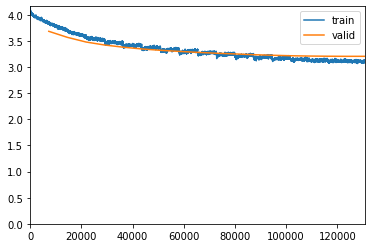

In [46]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(18, lr, wd=wd, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

In [47]:
learn_lm.save(f'{lang}fine_tuned2_sp15_multifit')
learn_lm.save_encoder(f'{lang}fine_tuned2_enc_sp15_multifit')

Save best LM learner and its encoder

In [48]:
learn_lm.save(f'{lang}fine_tuned_sp15_multifit')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_sp15_multifit')

## Fine-tuning "backward LM"

### Databunch

In [49]:
%%time
data_lm = (TextList.from_df(df_trn_val, path, cols='review_body', 
                            processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1, backwards=True))

CPU times: user 5min 56s, sys: 4.29 s, total: 6min 1s
Wall time: 3min 20s


In [50]:
data_lm.save(f'{path}/{lang}_databunch_lm_aws_sp15_multifit_bwd')

### Training

In [10]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_aws_sp15_multifit_bwd', bs=bs, backwards=True)

CPU times: user 2.08 s, sys: 796 ms, total: 2.88 s
Wall time: 4.29 s


In [11]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [12]:
%%time
perplexity = Perplexity()
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=lm_fns3_bwd, drop_mult=0.3, 
                                  metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 5.11 s, sys: 2.12 s, total: 7.22 s
Wall time: 37.2 s


In [13]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


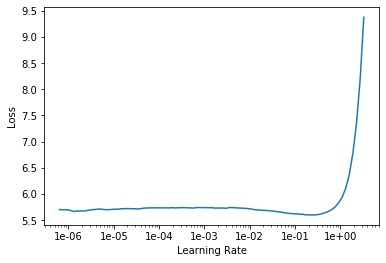

In [14]:
learn_lm.recorder.plot()

In [15]:
lr = 1e-3
lr *= bs/48

wd = 0.01

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,4.257432,3.958341,0.654464,0.345536,52.370190,05:09
1,4.094646,3.804180,0.640216,0.359784,44.888344,05:09


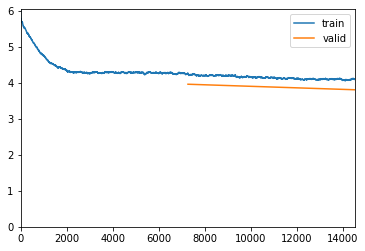

In [16]:
learn_lm.fit_one_cycle(2, lr*10, wd=wd, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

In [17]:
learn_lm.save(f'{lang}fine_tuned1_sp15_multifit_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned1_enc_sp15_multifit_bwd')

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.825450,3.684128,0.626069,0.373931,39.810345,06:55
1,3.696124,3.573147,0.612665,0.387335,35.628513,06:54
2,3.586809,3.487495,0.602351,0.397648,32.703949,06:54
3,3.527603,3.429095,0.595401,0.404600,30.848778,06:56
4,3.447804,3.389612,0.590796,0.409204,29.654394,06:56
5,3.418499,3.356368,0.586924,0.413076,28.684744,06:55
6,3.359818,3.330872,0.583699,0.416301,27.962671,06:55
7,3.353268,3.309207,0.581068,0.418932,27.363369,06:55
8,3.325843,3.290632,0.578592,0.421408,26.859846,06:54
9,3.301007,3.276146,0.576314,0.423686,26.473545,06:55


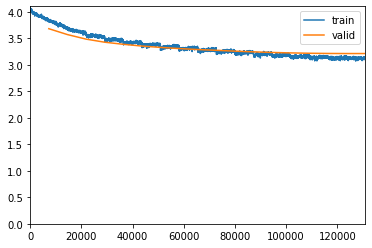

In [18]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(18, lr, wd=wd, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

In [19]:
learn_lm.save(f'{lang}fine_tuned2_sp15_multifit_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned2_enc_sp15_multifit_bwd')

Save best LM learner and its encoder

In [20]:
learn_lm.save(f'{lang}fine_tuned_sp15_multifit_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_sp15_multifit_bwd')

## Fine-tuning "forward Classifier"

In [21]:
bs = 18

### Databunch

In [22]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_aws_sp15_multifit', bs=bs)

CPU times: user 2.17 s, sys: 660 ms, total: 2.83 s
Wall time: 4.46 s


In [23]:
%%time
data_clas = (TextList.from_df(df_trn_val, path, vocab=data_lm.vocab, cols='review_body', 
                              processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=1))

CPU times: user 7min 37s, sys: 5.3 s, total: 7min 42s
Wall time: 4min 44s


In [24]:
%%time
data_clas.save(f'{lang}_textlist_class_sp15_multifit')

CPU times: user 6.29 s, sys: 1.1 s, total: 7.39 s
Wall time: 6.92 s


### Get weights to penalize loss function of the majority class

In [10]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit', bs=bs, num_workers=1)

CPU times: user 13.9 s, sys: 836 ms, total: 14.8 s
Wall time: 14.5 s


In [11]:
num_trn = len(data_clas.train_ds.x)
num_val = len(data_clas.valid_ds.x)
num_trn, num_val, num_trn+num_val

(199311, 22145, 221456)

In [12]:
trn_LabelCounts = np.unique(data_clas.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_clas.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([ 22694, 176617]), array([ 2412, 19733]))

In [13]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.8861377445299056, 0.11386225547009443],
 [0.891081508241138, 0.10891849175886203])

### Training (Loss = FlattenedLoss of weighted CrossEntropyLoss)

In [29]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit', bs=bs, num_workers=1)

CPU times: user 15.6 s, sys: 640 ms, total: 16.3 s
Wall time: 15.4 s


In [30]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [31]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15_multifit');

#### Change loss function

In [32]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [33]:
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

In [34]:
learn_c.loss_func

functools.partial(<function cross_entropy at 0x7f35bf4a9170>, weight=tensor([0.8861, 0.1139], device='cuda:0'))

#### Training

In [35]:
learn_c.freeze()

In [36]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


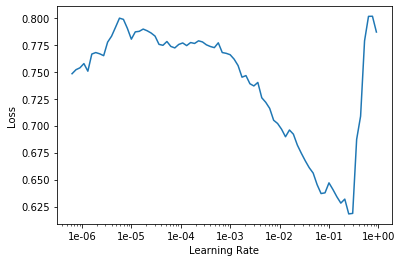

In [37]:
learn_c.recorder.plot()

In [38]:
lr = 2e-2
lr *= bs/48

wd = 0.01

In [39]:
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.401478,0.252659,0.891082,0.932395,04:16
1,0.347565,0.236773,0.897584,0.936454,04:44


In [40]:
learn_c.save(f'{lang}clas1_sp15_multifit')

In [41]:
learn_c.load(f'{lang}clas1_sp15_multifit');
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.389776,0.252349,0.870987,0.917717,05:00
1,0.363536,0.240705,0.899842,0.938135,05:04


In [42]:
learn_c.save(f'{lang}clas2_sp15_multifit')

In [43]:
learn_c.load(f'{lang}clas2_sp15_multifit');
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.330391,0.189252,0.939490,0.963542,04:48
1,0.287780,0.188604,0.953082,0.972258,05:00


In [44]:
learn_c.save(f'{lang}clas3_sp15_multifit')

In [45]:
learn_c.load(f'{lang}clas3_sp15_multifit');
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.259710,0.187999,0.954617,0.973095,05:58
1,0.222542,0.173242,0.957823,0.975082,06:47


In [46]:
learn_c.save(f'{lang}clas4_sp15_multifit')

In [47]:
learn_c.load(f'{lang}clas4_sp15_multifit');
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.224175,0.161613,0.953217,0.972256,10:45


In [48]:
learn_c.save(f'{lang}clas5_sp15_multifit')

In [49]:
learn_c.load(f'{lang}clas5_sp15_multifit')
learn_c.save(f'{lang}clas_sp15_multifit')

In [50]:
learn_c.load(f'{lang}clas_sp15_multifit');
learn_c.to_fp32().export(f'{lang}_classifier_sp15_multifit')

### Confusion matrix

In [14]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit', bs=bs, num_workers=1)

config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15_multifit');

learn_c.load(f'{lang}clas_sp15_multifit');

# put weight on cpu
loss_weights = torch.FloatTensor(trn_weights).cpu()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

CPU times: user 15.6 s, sys: 828 ms, total: 16.5 s
Wall time: 15.6 s


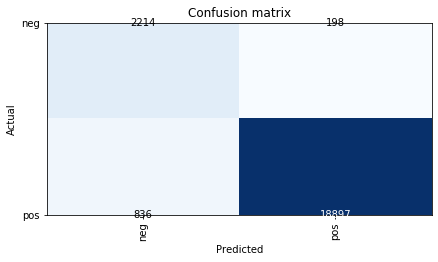

In [15]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(y), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])}')

# acc neg, acc pos
print(f'accuracy on negative reviews: {cm[0,0]/(cm[0,0]+cm[0,1])*100}') 
print(f'accuracy on positive reviews: {cm[1,1]/(cm[1,0]+cm[1,1])*100}')

[[ 2214   198]
 [  836 18897]]
accuracy global: 0.9533077444118311
accuracy on negative reviews: 91.7910447761194
accuracy on positive reviews: 95.76344195003294


In [17]:
learn_c.show_results()

text,target,prediction
"▁xxbos ▁xxup ▁ avertissement ▁du ▁7 ▁mai ▁2014 ▁: ▁ref ont e ▁de ▁ce ▁commentaire ▁avec ▁3 ▁paragraphe s ▁et ▁ ajout s ▁au ▁xxup ▁monde ▁xxup ▁de ▁xxup ▁la ▁xxup ▁symphonie , ▁soit ▁une ▁occasion ▁de ▁faire ▁l ' apologie ▁de ▁cette ▁forme ▁universelle ▁de ▁la ▁geste ▁symphonique ▁de ▁l ' harmo nia ▁xxmaj ▁ mund i ▁! ▁xxmaj ▁parmi ▁les ▁quelques ▁intégrale s ▁des ▁symphonies ▁de ▁xxmaj ▁beethoven",pos,pos
"▁xxbos ▁xxmaj ▁cette ▁xxup ▁saga ▁risque ▁de ▁devenir ▁une ▁vitrine ▁c inématographique , ▁si ▁l ' on ▁regarde ▁le ▁nombre ▁et ▁le ▁panel ▁d ' acteurs ▁connus , ▁qui ▁ont ▁été ▁pré ssent i . ▁xxup ▁un ▁xxup ▁top , ▁xxup ▁la ▁xxup ▁recette ▁xxup ▁: s y l ver ster ▁xxup ▁stallone ▁xxup ▁aux ▁xxup ▁commandes , ▁xxup ▁au ▁xxup ▁sens ▁xxup ▁propre ▁xxup ▁et ▁xxup ▁au ▁xxup ▁sens",pos,pos
"▁xxbos ▁xxmaj ▁tout ▁comme ▁il ▁l ' avait ▁fait ▁pour ▁la ▁première ▁saison ▁d ' hero es ▁en ▁xxup ▁dvd , ▁xxmaj ▁universal ▁france ▁nous ▁propose ▁un ▁coffret ▁ intégr al ▁de ▁xxmaj ▁battle star ▁xxmaj ▁galactica ▁encore ▁plus ▁complet ▁que ▁l ' édition ▁américaine , ▁déjà ▁que ▁celle - ci ▁est ▁bourré e ▁à ▁craquer ▁de ▁bonus , ▁documentaire s ▁et ▁commentaires . ▁xxmaj ▁nous ▁au rons ▁la ▁chance",pos,pos
"▁xxbos ▁xxmaj ▁on ▁peut ▁déplorer ▁que ▁la ▁musique ▁de ▁xxmaj ▁francis ▁xxmaj ▁poule nc ▁ne ▁soit ▁pas ▁mieux ▁représenté e ▁au ▁disque , ▁notamment ▁dans ▁la ▁production ▁actuelle . ▁xxmaj ▁est - ce ▁en ▁raison ▁d ’ un ▁mépris ▁à ▁l ’ égard ▁d ’ une ▁musique ▁qui ▁ s ’ est ▁toujours ▁voulu e ▁simple , ▁accessible , ▁charmante ▁et ▁peut - être ▁apparemment ▁peu ▁innovant e ▁? ▁xxmaj",pos,pos
"▁xxbos ▁xxmaj ▁personne ▁n ' im agi nait , ▁et ▁probablement ▁xxmaj ▁rossini ▁le ▁premier , ▁à ▁la ▁création ▁triomph ale ▁de ▁xxmaj ▁gu il la ume ▁xxmaj ▁ tell ▁à ▁xxmaj ▁paris ▁en ▁a o ût ▁18 29 , ▁que ▁ce ▁chef ▁d ' œuvre ▁d ' un ▁compositeur ▁de ▁ 37 ▁ans , ▁parvenu ▁au ▁sommet ▁de ▁sa ▁gloire , ▁serait ▁aussi ▁sa ▁dernière ▁œuvre ▁majeure , ▁pré",pos,pos


### Predictions some random sentences

In [23]:
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "on

In [24]:
# Get the prediction neg/pos
review = 'Ce produit est bizarre.'
pred = learn_c.predict(review)
print(pred[0], pred[2])

neg tensor([0.9973, 0.0027])


In [25]:
# The darker the word-shading in the below example, the more it contributes to the classification. 
txt_ci = TextClassificationInterpretation.from_learner(learn_c)
test_text = 'Ce produit est bizarre.'
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

In [26]:
txt_ci.intrinsic_attention(test_text)[1]

tensor([0.0309, 0.0451, 0.0830, 0.1374, 0.3396, 1.0000, 0.0805],
       device='cuda:0')

In [27]:
# tabulation showing the first k texts in top_losses along with their prediction, actual,loss, and probability of actual class.
# max_len is the maximum number of tokens displayed. If max_len=None, it will display all tokens.
txt_ci.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
"▁xxbos ▁xxmaj ▁le ▁plus ▁grand ▁film ▁sur ▁la ▁course ▁auto mo bile ▁avec ▁l ' immense ▁xxmaj ▁steve ▁mac ▁queen , ▁spectaculaire , ▁émouvant ▁et ▁surtout ▁très ▁re aliste ▁et ▁immersif .",pos,pos,7.32,1.00
"▁xxbos ▁xxmaj ▁les ▁manuscrit s ▁de ▁la ▁mer ▁mort e ▁ont ▁déjà ▁remis ▁en ▁cause ▁bien ▁des ▁théorie s ▁dog matique s ▁de ▁l ' eglise ▁catholique . ▁xxmaj ▁celle ▁ci ▁considère ▁toujours ▁comme ▁ hér étique ▁tout ▁ce ▁qui ▁ne ▁va ▁pas ▁dans ▁le ▁sens ▁de ▁ce ▁qu ' elle ▁a ▁décidé . ▁xxmaj ▁sans ▁remonter ▁à ▁l ' in qui s ition , ▁il ▁faut ▁bien ▁reconnaitre ▁que",pos,pos,5.65,1.00
▁xxbos ▁a ▁voir ▁et ▁à ▁revoir ▁pour ▁les ▁plus ▁petits ▁comme ▁pour ▁les ▁plus ▁grands ▁! ▁xxmaj ▁la ▁version ▁xxmaj ▁blu ▁ray ▁assure ▁une ▁super ▁qualité ...,pos,pos,5.32,1.00
▁xxbos ▁xxmaj ▁la ▁photographie ▁de ▁ce ▁film ▁à ▁petit ▁budget ▁ accuse ▁dés ▁l ' origine ▁une ▁forte ▁gran ul osité . ▁xxmaj ▁difficile ▁de ▁faire ▁des ▁miracle s ▁avec ▁ce ▁matériau ▁de ▁base ▁et ▁pourtant ... ▁xxmaj ▁sur ▁un ▁grand ▁écran ▁le ▁xxup ▁dvd ▁était ▁ ir regardable ▁et ▁voici ▁que ▁le ▁xxmaj ▁blu ▁xxmaj ▁ray ▁permet ▁de ▁redécouvrir ▁ce ▁chef ▁d ' oeuvre ▁dans ▁les ▁meilleurs ▁conditions ▁possibles,pos,pos,5.26,1.00
"▁xxbos ▁xxmaj ▁une ▁très ▁belle ▁qualité ▁: ▁lourds , ▁solide ▁et ▁réellement ▁très ▁beaux , ▁une ▁réussite ▁! ▁xxmaj ▁je ▁les ▁achète ▁pour ▁mon ▁compagnon ▁ aveugle ▁afin ▁qu ' il ▁puisse ▁voir ▁tactile ment ▁ces ▁animaux ▁vus ▁en ▁photo ▁enfant ▁ou ▁dont ▁il ▁a ▁entendu ▁parler . ▁xxmaj ▁de ▁longues ▁heures ▁d ' exploration , ▁recherches ▁sur ▁xxmaj ▁internet . . ▁xxmaj ▁excellent . ▁xxmaj ▁dommage ▁que ▁les ▁format",pos,pos,4.82,1.00


## Fine-tuning "backward Classifier"

In [56]:
bs = 18

### Databunch

In [57]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_aws_sp15_multifit_bwd', bs=bs, backwards=True)

CPU times: user 3.45 s, sys: 468 ms, total: 3.92 s
Wall time: 3.58 s


In [58]:
%%time
data_clas = (TextList.from_df(df_trn_val, path, vocab=data_lm.vocab, cols='review_body', 
                              processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=1, backwards=True))

CPU times: user 7min 58s, sys: 5.55 s, total: 8min 3s
Wall time: 5min 16s


In [59]:
%%time
data_clas.save(f'{lang}_textlist_class_sp15_multifit_bwd')

CPU times: user 6.45 s, sys: 1.05 s, total: 7.5 s
Wall time: 7.04 s


### Get weights to penalize loss function of the majority class

In [28]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit_bwd', bs=bs, num_workers=1, backwards=True)

CPU times: user 15.1 s, sys: 644 ms, total: 15.8 s
Wall time: 15.6 s


In [29]:
num_trn = len(data_clas.train_ds.x)
num_val = len(data_clas.valid_ds.x)
num_trn, num_val, num_trn+num_val

(199311, 22145, 221456)

In [30]:
trn_LabelCounts = np.unique(data_clas.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_clas.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([ 22694, 176617]), array([ 2412, 19733]))

In [31]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.8861377445299056, 0.11386225547009443],
 [0.891081508241138, 0.10891849175886203])

### Training (Loss = FlattenedLoss of weighted CrossEntropyLoss)

In [64]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit_bwd', bs=bs, num_workers=1, backwards=True)

CPU times: user 15.6 s, sys: 460 ms, total: 16 s
Wall time: 15.3 s


In [65]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [66]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15_multifit_bwd');

#### Change loss function

In [67]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [68]:
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

In [69]:
learn_c.loss_func

functools.partial(<function cross_entropy at 0x7f35bf4a9170>, weight=tensor([0.8861, 0.1139], device='cuda:0'))

#### Training

In [70]:
learn_c.freeze()

In [71]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


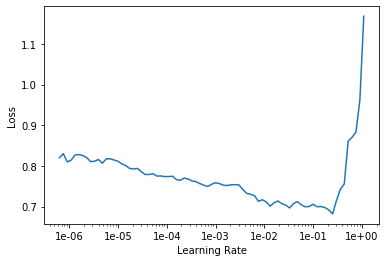

In [72]:
learn_c.recorder.plot()

In [73]:
lr = 2e-2
lr *= bs/48

wd = 0.01

In [74]:
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.440335,0.292225,0.893926,0.933869,04:19
1,0.427031,0.271362,0.903048,0.940470,04:46


In [75]:
learn_c.save(f'{lang}clas1_sp15_multifit_bwd')

In [76]:
learn_c.load(f'{lang}clas1_sp15_multifit_bwd');
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.338346,0.203508,0.934432,0.960377,05:46
1,0.316951,0.187639,0.938406,0.963090,05:53


In [77]:
learn_c.save(f'{lang}clas2_sp15_multifit_bwd')

In [78]:
learn_c.load(f'{lang}clas2_sp15_multifit_bwd');
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.272369,0.184813,0.941025,0.964649,05:58
1,0.210461,0.173936,0.950689,0.970924,06:14


In [79]:
learn_c.save(f'{lang}clas3_sp15_multifit_bwd')

In [80]:
learn_c.load(f'{lang}clas3_sp15_multifit_bwd');
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.244856,0.182789,0.956785,0.974709,09:22


In [81]:
learn_c.save(f'{lang}clas4_sp15_multifit_bwd')

In [82]:
learn_c.load(f'{lang}clas4_sp15_multifit_bwd')
learn_c.save(f'{lang}clas_sp15_multifit_bwd')

In [83]:
learn_c.load(f'{lang}clas_sp15_multifit_bwd');
learn_c.to_fp32().export(f'{lang}_classifier_sp15_multifit_bwd')

### Confusion matrix

In [32]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit_bwd', bs=bs, num_workers=1, backwards=True)

config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15_multifit_bwd');

learn_c.load(f'{lang}clas_sp15_multifit_bwd');

# put weight on cpu
loss_weights = torch.FloatTensor(trn_weights).cpu()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

CPU times: user 17.5 s, sys: 892 ms, total: 18.4 s
Wall time: 16.3 s


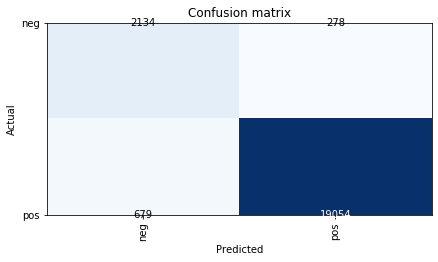

In [33]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(y), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])}')

# acc neg, acc pos
print(f'accuracy on negative reviews: {cm[0,0]/(cm[0,0]+cm[0,1])*100}') 
print(f'accuracy on positive reviews: {cm[1,1]/(cm[1,0]+cm[1,1])*100}')

[[ 2134   278]
 [  679 19054]]
accuracy global: 0.9567848272747799
accuracy on negative reviews: 88.47429519071311
accuracy on positive reviews: 96.55906349769423


In [35]:
learn_c.show_results()

text,target,prediction
. s ▁remarque ▁xxup ▁dans ▁continue ▁commentaire ▁le ▁xxmaj ]] le agi ▁ ▁xxmaj ▁maestro ▁xxmaj x x 6 l ▁6 ▁xxup ▁0 ▁4 ▁xxrep b : asin ▁[[ ▁xxup ]] ▁2 . ▁vol ▁collection ▁xxmaj t rich chu s ▁ ▁xxmaj ▁carl ▁xxmaj kk ta 5 92 00 b : asin ▁[[ ▁xxup ]]] ▁dvd ▁xxup ▁1 ▁/ s ▁cd 20 ▁[ ▁collection ▁xxmaj t rich chu s ▁,pos,pos
". ▁terminator ▁xxmaj ▁en ▁schwarzenegger ▁xxmaj arnold ▁ ▁xxmaj aperçoit ▁ ▁on ▁fin ▁de ▁générique ▁au ▁xxmaj . ▁jones ▁xxmaj indiana ▁ ▁xxmaj ▁à ▁référence ▁fait ▁xxmaj ▁: ▁film ▁du ▁fin ▁la ▁à ▁"") ▁\ ▁musée ▁un ▁dans ▁est ▁place a s ▁"" ▁\ ▁( ▁"" ▁\ um ▁muse ▁a ▁in s ong ▁bel ▁thing that ▁"" ▁\ ). ton mou ▁( ▁"" ▁\ ep she ▁"" ▁\ ▁en s",pos,pos
". g s ▁b ▁xxup ▁de ▁fan ▁tout ▁pour ▁posséder ▁à ▁coffret ▁un ▁xxmaj ) vf ▁( ▁xxup control - ▁u ▁bonus ▁le ▁dans ▁disponibles ▁informations ▁des intégralité ▁ ▁: ▁"" ▁\ le ac or ' l ▁"" ▁\ ) vf ▁( ▁xxup ▁visionnage ▁de ▁cours ▁en ▁vaisseaux ▁les ▁et ▁personnages ▁les ▁sur ▁informations ▁: ▁"" ▁\ le ac or ' l ▁"" ▁\ ▁- ▁: control - ▁u ▁xxmaj",pos,pos
"). ▁mélodies ▁ou ▁chansons ▁plusieurs ▁en nt ▁découpe ▁se ▁certaines ▁dont ▁œuvres ▁50 ▁de plus ▁( ▁nombre ▁du ▁tenu ▁compte ▁fastidieux ▁serait ▁qui ▁ce , ▁détail ▁le ▁dans ▁pas entre ’ ▁n ▁je ▁xxmaj . ▁interprètes ▁divers ▁par ▁chansons ▁et ▁mélodies ▁xxmaj ▁20 ▁à ▁16 ▁cd ▁xxup ) s r ophe ▁chris ▁xxmaj ▁harry ▁xxmaj ▁/ en te ▁six ▁xxmaj the ▁( ge ai ▁n ▁de ▁soir ▁un ▁xxmaj ▁–",pos,pos
"... ▁semaines ▁quelques ▁dans ni van gio ▁bon ▁xxmaj ▁chez ▁paraît ▁qui ]] tell ▁ ▁xxmaj ume la il ▁gu ▁xxmaj 8 f 45 89 v 00 b : asin ▁[[ ▁xxup ani gli ▁fo ▁xxmaj ▁/ er b le n ö ▁sh ▁xxmaj ▁version ▁la ▁de ▁dvd ▁xxup ▁le ▁avec ▁comparer ▁la ▁de ▁passionnant ▁être ▁va ▁il ▁xxmaj . ▁vidéo ▁que ▁audio ▁tant , ▁discographie ▁mince ▁la ▁de ▁sommet",pos,pos


### Predictions some random sentences

In [36]:
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "on

In [37]:
# Get the prediction neg/pos
review = 'Ce produit est bizarre.'
pred = learn_c.predict(review)
print(pred[0], pred[2])

neg tensor([0.9989, 0.0011])


In [38]:
# The darker the word-shading in the below example, the more it contributes to the classification. 
txt_ci = TextClassificationInterpretation.from_learner(learn_c)
test_text = 'Ce produit est bizarre.'
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

In [39]:
txt_ci.intrinsic_attention(test_text)[1]

tensor([0.3559, 1.0000, 0.1187, 0.1797, 0.1046, 0.0596, 0.0135],
       device='cuda:0')

In [40]:
# tabulation showing the first k texts in top_losses along with their prediction, actual,loss, and probability of actual class.
# max_len is the maximum number of tokens displayed. If max_len=None, it will display all tokens.
txt_ci.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
"▁xxbos ▁xxmaj ▁pour ▁la ▁3 ème ▁fois , ▁le ▁maitre ▁a ▁réuni ▁quelques ▁un s ▁des ▁meilleurs ▁disc ip les ▁de ▁la ▁gratte . ▁xxmaj ▁une ▁pure ▁merveille ▁à ▁nouveau . ▁xxmaj ▁vous ▁pouvez ▁acheter ▁en ▁confiance , ▁vous ▁ne ▁serez ▁pas ▁déçus ▁!!! ▁xxmaj ▁vivement ▁le ▁4 ème ▁xxrep ▁4 ▁ .",pos,pos,5.27,1.00
"▁xxbos ▁xxmaj ▁une ▁très ▁belle ▁qualité ▁: ▁lourds , ▁solide ▁et ▁réellement ▁très ▁beaux , ▁une ▁réussite ▁! ▁xxmaj ▁je ▁les ▁achète ▁pour ▁mon ▁compagnon ▁ aveugle ▁afin ▁qu ' il ▁puisse ▁voir ▁tactile ment ▁ces ▁animaux ▁vus ▁en ▁photo ▁enfant ▁ou ▁dont ▁il ▁a ▁entendu ▁parler . ▁xxmaj ▁de ▁longues ▁heures ▁d ' exploration , ▁recherches ▁sur ▁xxmaj ▁internet . . ▁xxmaj ▁excellent . ▁xxmaj ▁dommage ▁que ▁les ▁format",pos,pos,4.56,0.99
"▁xxbos ▁xxmaj ▁le ▁plus ▁grand ▁film ▁sur ▁la ▁course ▁auto mo bile ▁avec ▁l ' immense ▁xxmaj ▁steve ▁mac ▁queen , ▁spectaculaire , ▁émouvant ▁et ▁surtout ▁très ▁re aliste ▁et ▁immersif .",pos,pos,4.40,0.99
▁xxbos ▁xxmaj ▁la ▁photographie ▁de ▁ce ▁film ▁à ▁petit ▁budget ▁ accuse ▁dés ▁l ' origine ▁une ▁forte ▁gran ul osité . ▁xxmaj ▁difficile ▁de ▁faire ▁des ▁miracle s ▁avec ▁ce ▁matériau ▁de ▁base ▁et ▁pourtant ... ▁xxmaj ▁sur ▁un ▁grand ▁écran ▁le ▁xxup ▁dvd ▁était ▁ ir regardable ▁et ▁voici ▁que ▁le ▁xxmaj ▁blu ▁xxmaj ▁ray ▁permet ▁de ▁redécouvrir ▁ce ▁chef ▁d ' oeuvre ▁dans ▁les ▁meilleurs ▁conditions ▁possibles,pos,pos,4.33,0.99
"▁xxbos ▁xxmaj ▁un ▁nouvel ▁album ▁à ▁sa ▁hauteur , ▁simplement ▁génial , ▁j ' adore . ▁xxmaj ▁nouvel ▁album ▁dans ▁la ▁continuité ▁de ▁son ▁talent . ▁xxmaj ▁tout ▁simplement ▁excellent",pos,pos,4.09,0.99


## Ensemble

In [41]:
bs = 18

In [42]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [43]:
data_clas = load_data(path, f'{lang}_textlist_class_sp15_multifit', bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load(f'{lang}clas_sp15_multifit', purge=False);

In [44]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs),f1(preds,targs)

(tensor(0.9532), tensor(0.9733))

In [45]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs),f1(preds,targs)

(tensor(0.9532), tensor(0.9733))

In [46]:
data_clas_bwd = load_data(path, f'{lang}_textlist_class_sp15_multifit_bwd', bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.load(f'{lang}clas_sp15_multifit_bwd', purge=False);

In [47]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

(tensor(0.9568), tensor(0.9755))

In [48]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

(tensor(0.9568), tensor(0.9755))

In [49]:
preds_avg = (preds+preds_b)/2

In [50]:
accuracy(preds_avg,targs_b),f1(preds_avg,targs_b)

(tensor(0.9592), tensor(0.9768))

In [51]:
from sklearn.metrics import confusion_matrix

predictions = np.argmax(preds_avg, axis = 1)
cm = confusion_matrix(np.array(targs_b), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])}')

# acc neg, acc pos
print(f'accuracy on negative reviews: {cm[0,0]/(cm[0,0]+cm[0,1])*100}') 
print(f'accuracy on positive reviews: {cm[1,1]/(cm[1,0]+cm[1,1])*100}')

[[ 2196   216]
 [  688 19045]]
accuracy global: 0.9591781440505758
accuracy on negative reviews: 91.04477611940298
accuracy on positive reviews: 96.51345461916586
